In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models.logistic_regression import MyLogisticRegression
from metrics import f1_score, accuracy
import shap

In [6]:
heart_data = pd.read_csv("processed.cleveland.data")
heart_data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                     "exang", "oldpeak", "slope", "ca", "thal", "target"]
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


***Data:***<br>
* age - age in years <br>
* sex - (1 = male; 0 = female)<br>
* cp - chest pain type<br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)<br>
* chol - serum cholestoral in mg/dl<br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)<br>
* restecg - resting electrocardiographic results<br>
* thalach - maximum heart rate achieved<br>
* exang - exercise induced angina (1 = yes; 0 = no)<br>
* oldpeak - ST depression induced by exercise relative to rest<br>
* slope - the slope of the peak exercise ST segment<br>
* ca - number of major vessels (0-3) colored by flourosopy<br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect<br>
* target - have disease or not (1=yes, 0=no)<br>

In [7]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [8]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    object 
 12  thal      302 non-null    object 
 13  target    302 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


In [9]:
_ = heart_data.apply(lambda col: print(f"{col.name}: {col.sort_values().unique()}\n"))

age: [29. 34. 35. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.
 70. 71. 74. 76. 77.]

sex: [0. 1.]

cp: [1. 2. 3. 4.]

trestbps: [ 94. 100. 101. 102. 104. 105. 106. 108. 110. 112. 114. 115. 117. 118.
 120. 122. 123. 124. 125. 126. 128. 129. 130. 132. 134. 135. 136. 138.
 140. 142. 144. 145. 146. 148. 150. 152. 154. 155. 156. 158. 160. 164.
 165. 170. 172. 174. 178. 180. 192. 200.]

chol: [126. 131. 141. 149. 157. 160. 164. 166. 167. 168. 169. 172. 174. 175.
 176. 177. 178. 180. 182. 183. 184. 185. 186. 187. 188. 192. 193. 195.
 196. 197. 198. 199. 200. 201. 203. 204. 205. 206. 207. 208. 209. 210.
 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224.
 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 239.
 240. 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 252. 253. 254.
 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267. 268.
 269. 270. 271. 273. 274

In [10]:
heart_data = heart_data.replace("?", np.nan).dropna()
heart_data = heart_data.reset_index(drop = True)
heart_data['target'] = heart_data['target'].replace([2,3,4],1)
heart_data = heart_data.astype(float)

In [11]:
def rename_values(df, rename_dict, column_name):
    return [rename_dict[x] if x in rename_dict.keys() else x for x in df[column_name]]

cp_dict = {1:"typical angina" , 2: "atypical angina", 3: "non-anginal pain", 4:"asymptomatic"}
heart_data["cp"]  = rename_values(heart_data, cp_dict, "cp")

restecg_dict = {0: "normal", 1: "ST-T wave abnormality", 2:"probable or definite left ventricular hypertrophy"}
heart_data["restecg"]  = rename_values(heart_data, restecg_dict, "restecg")

slope_dict = {1: "upsloping", 2: "flat", 3:"downsloping"}
heart_data["slope"]  = rename_values(heart_data, slope_dict, "slope")

thal_dict = {3.0: "normal", 6.0: "fixed defect", 7.0:"reversable defect"}
heart_data["thal"] = rename_values(heart_data, thal_dict, "thal")

In [12]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67.0,1.0,asymptomatic,160.0,286.0,0.0,probable or definite left ventricular hypertrophy,108.0,1.0,1.5,flat,3.0,normal,1.0
1,67.0,1.0,asymptomatic,120.0,229.0,0.0,probable or definite left ventricular hypertrophy,129.0,1.0,2.6,flat,2.0,reversable defect,1.0
2,37.0,1.0,non-anginal pain,130.0,250.0,0.0,normal,187.0,0.0,3.5,downsloping,0.0,normal,0.0
3,41.0,0.0,atypical angina,130.0,204.0,0.0,probable or definite left ventricular hypertrophy,172.0,0.0,1.4,upsloping,0.0,normal,0.0
4,56.0,1.0,atypical angina,120.0,236.0,0.0,normal,178.0,0.0,0.8,upsloping,0.0,normal,0.0


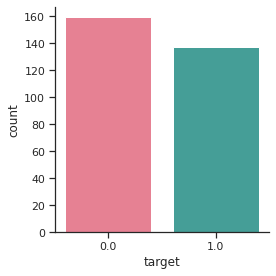

In [13]:
sns.set_theme(style="ticks")
sns.catplot(x = "target", data = heart_data,palette = "husl", kind = "count" ,height = 4)
plt.show()

On the plot we could see, that our classes are balanced

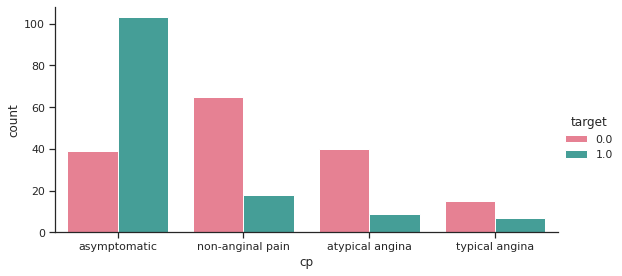

In [14]:
sns.catplot(x = "cp", hue = "target", kind ="count", data = heart_data,palette = "husl", height = 4, aspect = 2)

As we can see, most patients with asymptomatic chest pain have a heart disease

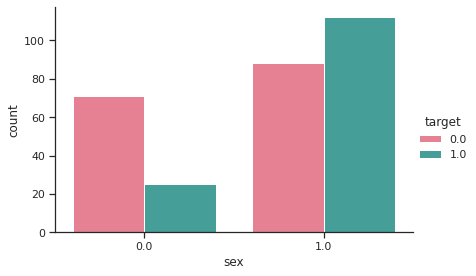

In [15]:
sns.catplot(x = "sex", hue="target", kind ="count", data = heart_data,palette = "husl", height = 4, aspect = 1.5)

In [16]:
heart_data = pd.get_dummies(heart_data, columns = ["cp","restecg", "slope", "thal"])
heart_data.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,cp_typical angina,restecg_ST-T wave abnormality,restecg_normal,restecg_probable or definite left ventricular hypertrophy,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1.0,...,0,0,0,1,0,1,0,0,1,0
1,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1.0,...,0,0,0,1,0,1,0,0,0,1
2,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0.0,...,0,0,1,0,1,0,0,0,1,0
3,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0.0,...,0,0,0,1,0,0,1,0,1,0
4,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,0.0,0.0,...,0,0,1,0,0,0,1,0,1,0


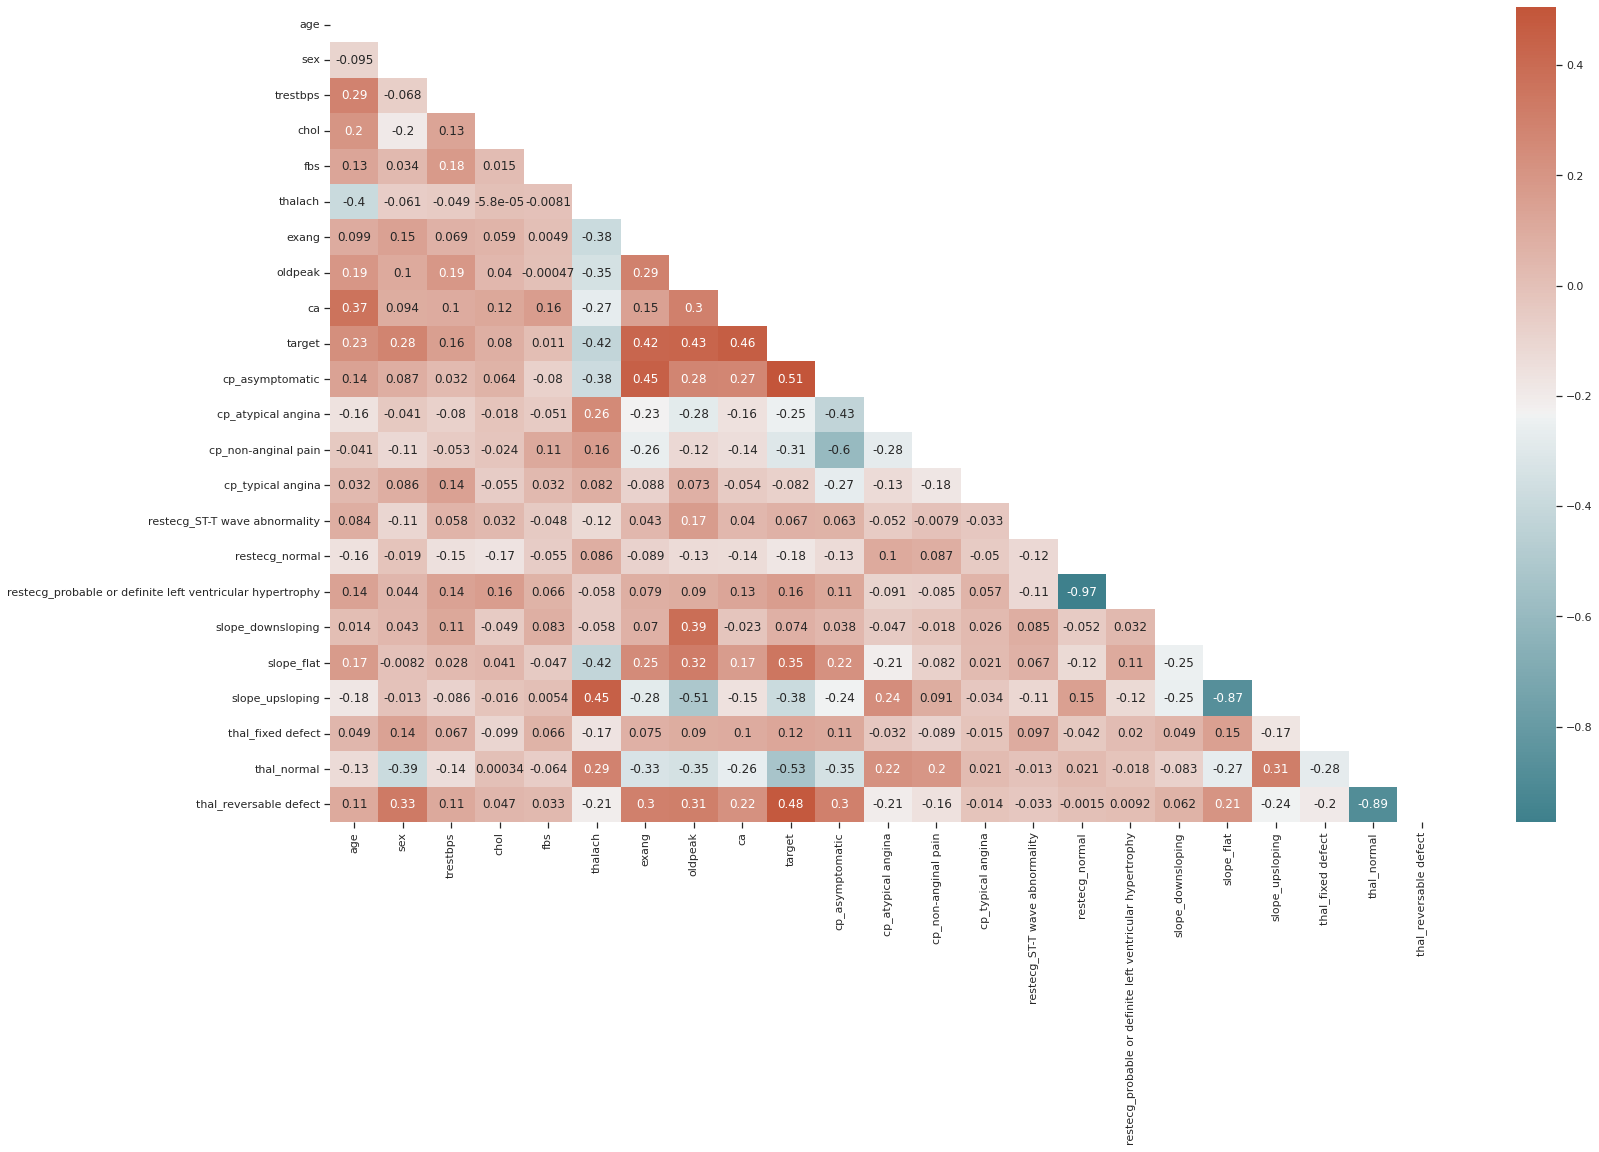

In [17]:
correlation = heart_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
mask = np.triu(np.ones_like(correlation,dtype = bool))
plt.figure(figsize = (25,15))
ax = sns.heatmap(correlation, cmap = cmap, annot = True, mask = mask)
plt.show()

There aren't any redundant features since there are no highly correlated variables

In [18]:
X = heart_data.drop("target", axis = 1)
y = heart_data["target"].values

X_standart = ((X - np.mean(X))/ np.std(X))
X_stand_shuffled = X_standart.sample(frac = 1)
y_shuffled = y[X_stand_shuffled.index]


X_train, X_val, X_test = np.split(X_stand_shuffled, [int(0.6*len(y_shuffled)), int(0.8 * len(y_shuffled))])
y_train, y_val, y_test = np.split(y_shuffled, [int(0.6*len(y_shuffled)), int(0.8 * len(y_shuffled))])

In [19]:
my_logistic = MyLogisticRegression(learning_rate = 0.1, max_iterations = 100)
my_logistic_history = my_logistic.fit(X_train,y_train, X_val, y_val)

y_pred = my_logistic.predict(X_test)

0/100: Loss -> 0.693, train F1 -> 0.819, val f1 -> 0.836
50/100: Loss -> 0.363, train F1 -> 0.845, val f1 -> 0.776
100/100: Loss -> 0.344, train F1 -> 0.845, val f1 -> 0.776


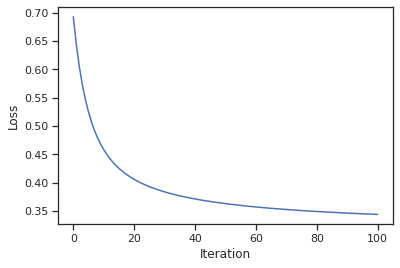

In [20]:
figure = sns.lineplot(x = my_logistic_history.keys(), y = my_logistic_history.values())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show(figure)

In [21]:
y_test_predicted = my_logistic.predict(X_test)
print(f"Test metrics:\naccuracy -> {accuracy(y_test, y_test_predicted)}\nf1-score -> {f1_score(y_test, y_test_predicted)}")

Test metrics:
accuracy -> 0.85
f1-score -> 0.830188679245283
